# Creating a Simple Neural Network with PyTorch

In this notebook, we build and train a simple neural network that uses the FashionMNIST dataset to classify images.

# Step 1: Install PyTorch and Import Necessary Libraries

First, ensure you have PyTorch and torchvision installed in your environment. If not, you can install them using pip:

In [4]:
# Import the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Load the FashionMNIST Dataset and Split Into Training and Validation Sets

Use the transforms module to convert images into PyTorch tensors and normalize them.  Load the FashionMIST dataset, split it into training and test sets, then load it into DataLoaders.

In [5]:
# Create a transform to preprocess the images
# This step converts an image into a multi-dimensional array of data
# that PyTorch can work with (called a PyTorch tensor)
# It also normalizes the images to the same intensity or brightness so it's
# easier to compare them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor
])

# Load the FashionMNIST dataset ( https://github.com/zalandoresearch/fashion-mnist)
# The dataset is pre-split into a training set (60,000 images)
# and a test set (10,000 images) so we'll pass in train=True
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

# Split the training data into training and validation sets
# Let's use 10% of the training data for validation
num_train = len(train_data)
num_val = int(0.1 * num_train)
train_data, val_data = random_split(train_data, [num_train - num_val, num_val])

# Define the DataLoaders, a utility class that makes it easy to
# iterate through datasets
# batch_size is how many data samples (i.e., images) are passed through
# the network at one time during the training process
batch_size = 32  # You can adjust the batch size

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Data loaded and DataLoaders are ready!")

100.0%
100.0%
100.0%
100.0%


Data loaded and DataLoaders are ready!


# Step 3: Visualize Examples from the MNIST Fashion Dataset

It's always nice to be able to visualize the data you're working with.  We'll use matplotlib to plot a sample of images.

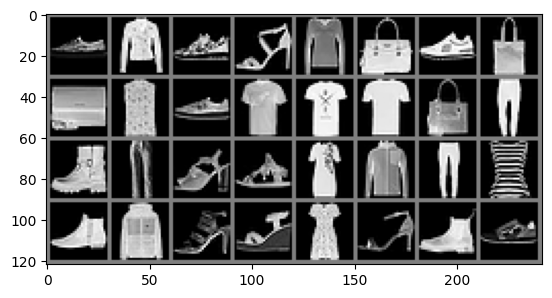

Labels: Sneaker Coat Sneaker Sandal Pullover Bag Sneaker Bag Bag Shirt Sneaker T-shirt/top T-shirt/top T-shirt/top Bag Trouser Ankle boot Trouser Sandal Sandal Dress Coat Trouser Shirt Ankle boot Coat Sandal Sandal Dress Sandal Ankle boot Sneaker


In [ ]:
# Class labels for the FashionMNIST dataset
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to show an image
# Effectively reverses the transform step from earlier
#  matplotlib:   https://matplotlib.org/, https://github.com/matplotlib/matplotlib
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from Tensor image
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(len(labels))))


# Step 4: Define the Architecture and Create the Neural Network

For classifying FashionMNIST images, a Convolutional Neural Network (CNN) is typically the most suitable choice due to its ability to capture spatial hierarchies in image data.  CNNs are especially good at tasks involving images because they use convolutional layers that apply filters to raw pixel data.
 This allows the network to learn features from the images in a hierarchical manner.  This means lower layers might learn to detect edges or textures, while deeper layers can recognize more complex patterns or objects.

In [10]:
# Define the CNN architecture
class FashionCNN(nn.Module):
    # Initialize the convolutional layers, pooling layer, linear layers, and dropout layer
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Convolutional layer (sees 14x14x32 tensor after pooling)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Linear layer (64 * 7 * 7 = 3136)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Linear layer (128 -> 10)
        self.fc2 = nn.Linear(128, 10)
        # Dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)

    # Define the forward pass through the network (i.e., how data moves through the layers)
    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten image input
        x = x.view(-1, 64 * 7 * 7)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add 2nd hidden layer, with 10 output units for 10 classes
        x = self.fc2(x)
        return x

# Create an instance of the CNN, making it ready to be trained with data
model = FashionCNN()
print(model)

# Specify the loss function
# This will tell us the difference between what the model predicted
# and what the correct (labeled) answer was
# Cross Entropy is a common loss function for classification problems
criterion = nn.CrossEntropyLoss()

# Specify optimizer
# This minimizes the loss (cost) by adjusting weights, biases and learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Step 5: Train the Model, Feeding in the Training Data

This training loop iterates over the dataset multiple times (called epochs), feeds batches of images and their corresponding labels to the model, computes the loss, and updates the model parameters.

In [ ]:
num_epochs = 10  # Number of epochs to train for

for epoch in range(1, num_epochs + 1):
    # Keep track of training loss
    train_loss = 0.0

    ###################
    # Train the model #
    ###################
    model.train()  # Prepare model for training
    for data, target in train_loader:
        # Move images and labels to GPU if CUDA is available (to increase speed and efficiency)
        # CUDA is a parallel computing platform from NVIDIA
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #  or Intel GPU
        elif torch.xpu.is_available():
            data, target = data.xpu(), target.xpu()
        #  or AMD ROCm GPU (???)
        #
        # Clear the gradients of all optimized variables
        # Before the model can update weights during training, it needs a clean slate
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)

    # print training statistics
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

Epoch: 1 	Training Loss: 0.375391
Epoch: 2 	Training Loss: 0.365721
Epoch: 3 	Training Loss: 0.355484
Epoch: 4 	Training Loss: 0.345958
Epoch: 5 	Training Loss: 0.340688
Epoch: 6 	Training Loss: 0.331660
Epoch: 7 	Training Loss: 0.325555
Epoch: 8 	Training Loss: 0.320680
Epoch: 9 	Training Loss: 0.315396
Epoch: 10 	Training Loss: 0.310170
Epoch: 11 	Training Loss: 0.308461
Epoch: 12 	Training Loss: 0.301363
Epoch: 13 	Training Loss: 0.297539
Epoch: 14 	Training Loss: 0.294676
Epoch: 15 	Training Loss: 0.291390
Epoch: 16 	Training Loss: 0.283978
Epoch: 17 	Training Loss: 0.285327
Epoch: 18 	Training Loss: 0.283254
Epoch: 19 	Training Loss: 0.278674
Epoch: 20 	Training Loss: 0.274160
Epoch: 21 	Training Loss: 0.268409
Epoch: 22 	Training Loss: 0.268833
Epoch: 23 	Training Loss: 0.266030
Epoch: 24 	Training Loss: 0.261675
Epoch: 25 	Training Loss: 0.259733
Epoch: 26 	Training Loss: 0.255089
Epoch: 27 	Training Loss: 0.252595
Epoch: 28 	Training Loss: 0.252633
Epoch: 29 	Training Loss: 0.2

# Step 6: Evaluate the Model Using the Validation Dataset

This inference loop will evaluate the model's performance on the validation dataset. It calculates the overall accuracy and visualizes a subset of  predictions.

Accuracy on the validation set: 93.12%


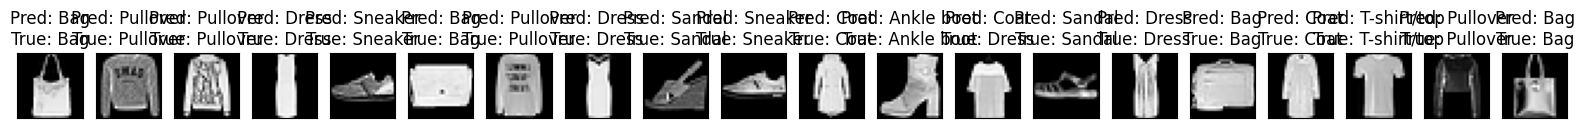

In [ ]:
# Some layers behave differently during training vs. evaluation
# So set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Set up visualization values
images_to_show = 10
fig = plt.figure(figsize=(20, 3))  # Adjust the figure size so images are not too cramped

# Updating gradients is only required during training
# No gradients needed for evaluation
with torch.no_grad():
    # Loop through validation data, move it to the GPU if available
    # and make predictions for each image, updating accuracy counters
    for i, (data, target) in enumerate(val_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #  or Intel GPU
        elif torch.xpu.is_available():
            data, target = data.xpu(), target.xpu()
        #  or AMD ROCm GPU (???)
        #            
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Visualize the images and predictions
        if i < images_to_show:
            ax = fig.add_subplot(1, images_to_show, i + 1, xticks=[], yticks=[])
            # Convert image to displayable format
            img = data.cpu().data[i].numpy()
            img = img.squeeze()  # Remove the channel dimension
            ax.imshow(img, cmap="gray")
            ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[target[i]]}")

# Calculate accuracy for all predictions, then print
accuracy = 100 * correct / total
print(f'Accuracy on the validation set: {accuracy:.2f}%')

plt.show()